In [9]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os
from torchvision import transforms
from PIL import Image



## Mathematical formulation
We train a score network $s_\theta(x,\sigma)$ to approximate the score of the perturbed data distribution:
$$\nabla_x \log p_\sigma(x) \approx s_\theta(x,\sigma).$$

**Noise perturbation**
$$x_\sigma = x + \sigma z, \quad z \sim \mathcal{N}(0,I).$$

**Denoising score matching objective (weighted/annealed)**
$$\mathcal{L}(\theta)=\mathbb{E}_{x,z,\sigma}\left[\lambda(\sigma)\,\left\|s_\theta(x_\sigma,\sigma)+\frac{z}{\sigma}\right\|_2^2\right],$$
with a common choice $\lambda(\sigma)=\sigma^2$.

**Annealed Langevin dynamics (sampling)**
$$x_{t+1}=x_t+\epsilon_t\,s_\theta(x_t,\sigma_t)+\sqrt{2\epsilon_t}\,\eta_t,\quad \eta_t\sim\mathcal{N}(0,I).$$

In practice, we schedule $\sigma_t$ from large to small (annealing) and optionally scale the step size as $\epsilon_t \propto \sigma_t^2$ for stability.

In [10]:
""" 
Custom Dataset for CelebA images
"""
class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir: Directory containing images
            transform: Image transformations
            max_images: Limit number of images (useful for testing)
        """
        self.root_dir = root_dir
        self.transform = transform
        
        if not os.path.exists(self.root_dir):
            raise ValueError(f"Directory {self.root_dir} does not exist.")
        
        print(f"Loading image paths from {self.root_dir}...")
        
        # Fast path listing - check if images are directly in root_dir
        if any(f.endswith(('.png', '.jpg', '.jpeg')) for f in os.listdir(self.root_dir)[:10]):
            self.image_paths = [
                os.path.join(self.root_dir, f) 
                for f in os.listdir(self.root_dir) 
                if f.endswith(('.png', '.jpg', '.jpeg'))
            ]
        else:
            self.image_paths = []
            for root, _, files in os.walk(self.root_dir):
                for file in files:
                    if file.endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(os.path.join(root, file))
        
        if len(self.image_paths) == 0:
            raise ValueError(f"No image files found in directory {self.root_dir}.")
                
        print(f"✓ Found {len(self.image_paths)} images")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image


In [11]:
# mean = torch.tensor([0.5061, 0.4254, 0.3828])
# std  = torch.tensor([0.2659, 0.2452, 0.2413])
#TODO : normalization to [-1,1]
transform = transforms.Compose([
    transforms.CenterCrop(178),
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

inv_normalize = transforms.Normalize(
    (-1.0, -1.0, -1.0),
    (2.0, 2.0, 2.0)
)

In [31]:
print("="*60)
print("DATASET INITIALIZATION")
print("="*60)
cur_dir = os.getcwd()
dataset = CelebADataset(
    root_dir=os.path.join(cur_dir, "..\\data\\celeba\\img_align_celeba"), 
    transform=transform,
)
print(f"✓ Dataset ready with {len(dataset)} images")


DATASET INITIALIZATION
Loading image paths from c:\Academics\GenerativeModel\Score models\NCSN\..\data\celeba\img_align_celeba...
✓ Found 63736 images
✓ Dataset ready with 63736 images


In [13]:
#! instead of fourier features, we should try for gausian features 
class FourierTimeEmbedding(nn.Module):
    def __init__(self,dim):
        super(FourierTimeEmbedding,self).__init__()
        assert dim % 2 == 0, "Dimension must be even"
        self.dim = dim
        self.nn = nn.Sequential(
            nn.Linear(dim, dim),
            nn.SELU(),
            nn.Linear(dim, dim)
        )
    def forward(self,t):
        device = t.device
        half_dim = self.dim // 2
        freqs = torch.exp(
            -torch.log(torch.tensor(10000.0)) * torch.arange(0, half_dim, dtype=torch.float32, device=device) / half_dim
        )
        args = t.unsqueeze(1) * freqs.unsqueeze(0)
        sincos = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        return self.nn(sincos)
    
        
        
        

In [14]:
class DownSample(nn.Module):
    """
    Downsample block using strided convolution.
    shape(B,C,H,W) -> (B,C,H/2,W/2)
    """
    def __init__(self,in_channels,out_channels):
        super(DownSample,self).__init__()
        self.conv = nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=2,padding=1)
    def forward(self,x):
        return self.conv(x)
class UpSample(nn.Module):
    """
    Upsample block using nearest neighbor interpolation followed by a convolution.
    shape(B,C,H,W) -> (B,C,H*2,W*2)
    """
    def __init__(self,in_channels,out_channels):
        super(UpSample,self).__init__()
        self.conv = nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1)
    def forward(self,x):
        x = F.interpolate(x,scale_factor=2,mode='nearest') # mode = 'bilinear' can also be used
        return self.conv(x)



In [15]:
class ResBlockFiLM(nn.Module):
    """
    Residual block with FiLM (Feature-wise Linear Modulation) conditioning.
    Given a feature map x E R^(B,C,H,W)
        FiLM(X|γ,β)=γ⊙X+β
    where γ,β E R^(B,C) are the FiLM parameters (parameters generated from time embedding)
    
    """
    def __init__(self,in_channels,out_channels,emb_dim = 256, groups = 8):
        super(ResBlockFiLM,self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.groups = groups
        assert self.out_channels % self.groups == 0, "out_channels must be divisible by groups"
        self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1)
        self.groupnorm1 = nn.GroupNorm(groups,out_channels)
        self.groupnorm2 = nn.GroupNorm(groups,out_channels)
        # FilM parameter generator
        self.film = nn.Linear(emb_dim, out_channels * 4)
        # residual connection 
        if in_channels != out_channels:
            self.residual_conv = nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=1)
        else:
            self.residual_conv = nn.Identity()
    def forward(self,x,emb):
        """ 
        x: feature map of shape (B,C,H,W)
        emb: time embedding of shape (B,emb_dim)
        """
        B,C,H,W = x.shape
        h = self.conv1(x)
        h = self.groupnorm1(h)
        conditioner = self.film(emb)
        # Generate FiLM parameters
        gamma1,beta1,gamma2,beta2 = conditioner.chunk(4,dim=-1)
        gamma1 = gamma1[:, :, None, None]
        beta1 = beta1[:, :, None, None]
        gamma2 = gamma2[:, :, None, None]
        beta2 = beta2[:, :, None, None]
        h = gamma1 * h + beta1
        h = F.silu(h)
        h = self.conv2(h)
        h = self.groupnorm2(h)
        h = gamma2 * h + beta2
        h = F.silu(h)
        # Residual connection (skip connection)
        return h + self.residual_conv(x)


In [16]:
class EncoderBlock(nn.Module):
    """
    single encoder block
    """
    def __init__(self,in_channels,out_channels,emb_dim  : int = 256,num_res_blocks : int  = 1,downsample : bool=True):
        super(EncoderBlock,self).__init__()
        self.res_blocks = nn.ModuleList([
            ResBlockFiLM(
                in_channels = in_channels if i == 0 else out_channels,
                out_channels = out_channels,
                emb_dim = emb_dim
            ) for i in range(num_res_blocks)
        ])
        self.downsample = DownSample(out_channels, out_channels) if downsample else nn.Identity()
    def forward(self,x,emb):
        for res_block in self.res_blocks:
            x = res_block(x,emb)
        x_down = self.downsample(x)
        return x_down, x  # return downsampled output and skip connection

In [17]:
class AttentionBlock(nn.Module):
    """  
    gated attention block
    inputs:
     Encoder feature map: (B,Cx,Hx,Wx)
     Decoder gating signal (coarser, semantic) : (B,Cg,Hg,Wg) #! Hx=2*Hg, Wx=2*Wg
    outputs:
     attended feature map: (B,Cx,Hx,Wx)     
    """
    def __init__(self,in_channels_x,in_channels_g,inter_channels = None):
        super(AttentionBlock,self).__init__()
        if inter_channels is None:
            inter_channels = in_channels_x // 2
        self.Wg = nn.Conv2d(in_channels_g,inter_channels,kernel_size=1,stride=1)
        self.Wx = nn.Conv2d(in_channels_x,inter_channels,kernel_size=1,stride=2)
        self.psi = nn.Sequential(
            nn.Conv2d(inter_channels,1,kernel_size=1,stride=1),
            nn.Sigmoid()
        )
    def forward(self,x,g):
        """  
        x: Encoder feature map (B,Cx,Hx,Wx) 
        g: Decoder gating signal (B,Cg,Hg,Wg)
        """
        g1 = self.Wg(g)
        x1 = self.Wx(x)
        psi = F.relu(g1 + x1)
        psi = self.psi(psi) # shape (B,1,Hg,Wg)
        psi = F.interpolate(psi, size=x.shape[2:], mode='nearest') # resampler 
        return x * psi
        

In [18]:
class DecoderBlock(nn.Module):
    """   
    single decoder block
    """
    def __init__(self,in_channels,out_channels,emb_dim : int = 256,num_res_blocks :int = 1,upsample : bool = True,use_attention : bool = False):
        super(DecoderBlock,self).__init__()
        self.res_blocks = nn.ModuleList([
            ResBlockFiLM(
                in_channels = 2*out_channels if i == 0 else out_channels,
                out_channels = out_channels,
                emb_dim = emb_dim
            ) for i in range(num_res_blocks)
        ])
        self.upsample = UpSample(in_channels,out_channels) if upsample else nn.Identity()
        self.use_attention = use_attention
        if self.use_attention:
            self.attention = AttentionBlock(in_channels_g= in_channels, in_channels_x= out_channels)
    def forward(self,x,skip,emb):
        if self.use_attention:
            skip = self.attention(skip,x) # attention mechanism
        x = self.upsample(x) # upsampling the decoder feature map
        x = torch.cat([x, skip], dim=1)  # concatenate skip connection
        for res_block in self.res_blocks:
            x = res_block(x, emb)
        return x
        

In [19]:
class ScoreModel(nn.Module):
    def __init__(self, in_channels : int = 3, 
                 base_channels : int = 64,
                 channel_mults : tuple = (1,2,4,8),
                 emb_dim : int = 256,
                 num_res_blocks : int = 2,
                 use_attention : bool = True):
        super(ScoreModel,self).__init__()
        self.in_channels = in_channels
        self.base_channels = base_channels
        self.channels = [base_channels * m for m in channel_mults]
        self.emb_dim = emb_dim
        self.num_res_blocks = num_res_blocks
        self.use_attention = use_attention
        # Initial convolution
        self.initial_conv = nn.Conv2d(in_channels, base_channels, kernel_size=3, stride=1, padding=1)
        # Time embedding
        self.time_embedding = FourierTimeEmbedding(emb_dim)
        # Encoder blocks
        self.encoder_blocks = nn.ModuleList()
        in_ch = base_channels
        for ch in self.channels:
            self.encoder_blocks.append(
                EncoderBlock(
                    in_channels = in_ch,
                    out_channels = ch,
                    emb_dim = emb_dim,
                    num_res_blocks = num_res_blocks,
                    downsample = True
                )
            )
            in_ch = ch
        
        # Bottleneck ResBlocks
        self.bottleneck = nn.ModuleList([
            ResBlockFiLM(
                in_channels = in_ch,
                out_channels = in_ch,
                emb_dim = emb_dim
            ) for _ in range(num_res_blocks)
        ])
        
        # decoder blocks
        self.decoder_blocks = nn.ModuleList()
        reversed_channels = self.channels[::-1]
        for i,ch in enumerate(reversed_channels):
            self.decoder_blocks.append(
                DecoderBlock(
                    in_channels = in_ch,
                    out_channels = ch,
                    emb_dim = emb_dim,
                    num_res_blocks = num_res_blocks,
                    upsample = True,
                    use_attention = use_attention
                )
            )
            in_ch = ch
            
        # Final normalization and convolution
        self.final_groupnorm = nn.GroupNorm(8, in_ch)
        self.final_act = nn.SELU()
        self.final_conv = nn.Conv2d(in_ch, in_channels, kernel_size=3, stride=1, padding=1)
    def forward(self,x,t):
        """ 
        x: input image tensor of shape (B,C,H,W)
        t: time steps tensor of shape (B,)
        """
        # Initial convolution
        x = self.initial_conv(x)
        # Time embedding
        t_emb = self.time_embedding(t)
        # Encoder path
        skip_connections = []
        for encoder in self.encoder_blocks:
            x, skip = encoder(x, t_emb)
            skip_connections.append(skip)
        # Bottleneck
        for bottleneck_block in self.bottleneck:
            x = bottleneck_block(x, t_emb)
        # Decoder path
        for decoder in self.decoder_blocks:
            skip = skip_connections.pop()
            x = decoder(x, skip, t_emb)
        # Final normalization and convolution
        x = self.final_groupnorm(x)
        x = self.final_act(x)
        x = self.final_conv(x)
        return x

In [20]:
score_model = ScoreModel()
print(score_model)

ScoreModel(
  (initial_conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_embedding): FourierTimeEmbedding(
    (nn): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): SELU()
      (2): Linear(in_features=256, out_features=256, bias=True)
    )
  )
  (encoder_blocks): ModuleList(
    (0): EncoderBlock(
      (res_blocks): ModuleList(
        (0-1): 2 x ResBlockFiLM(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (groupnorm1): GroupNorm(8, 64, eps=1e-05, affine=True)
          (groupnorm2): GroupNorm(8, 64, eps=1e-05, affine=True)
          (film): Linear(in_features=256, out_features=256, bias=True)
          (residual_conv): Identity()
        )
      )
      (downsample): DownSample(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
    )
    (1): E

In [21]:
print(sum(p.numel() for p in score_model.parameters() if p.requires_grad))  # Count trainable parameters

49560231


In [32]:
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)
len(dataloader)  

498

In [41]:
# plot images 
import matplotlib.pyplot as plt
import math
from IPython.display import display, clear_output

def _plot_images(
    tensor_images,
    num_cols=None,  
    inv_transform=None,
    show=True,
    clear=True
):
    if inv_transform is not None:
        tensor_images = inv_transform(tensor_images)
    
    num_images = tensor_images.shape[0]
    if num_cols is None:
        num_cols = int(math.sqrt(num_images))
    num_rows = math.ceil(num_images / num_cols)
    fig,axes = plt.subplots(num_rows,num_cols,figsize=(num_cols*2,num_rows*2))
    for i in range(num_rows*num_cols):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row,col] if num_rows > 1 else axes[col]
        ax.axis('off')
        if i < num_images:
            img = tensor_images[i].permute(1,2,0).cpu().numpy()
            img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0,1] for display
            ax.imshow(img)

    plt.tight_layout()
    if show:
        if clear:
            clear_output(wait=True)
        plt.show()
        plt.close(fig)
        return None
    return fig


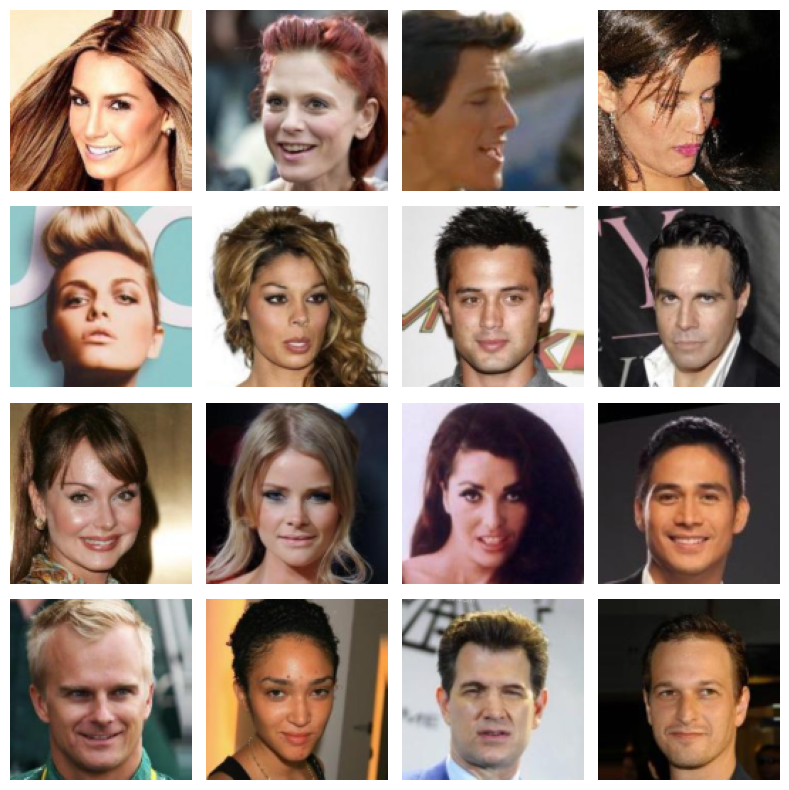

In [42]:
images = [dataset[i] for i in range(16)]
images = torch.stack(images,dim=0)
_ = _plot_images(images, inv_transform=inv_normalize)

In [36]:
import math
# --- Configuration ---
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SIGMA_MIN = 0.01
SIGMA_MAX = 50
T = 250
lr = 1e-4
epochs = 10
Batch_size = 32
sample_size = 8
log_scales = torch.linspace(math.log(SIGMA_MIN),math.log(SIGMA_MAX),T).to(device)
scales = torch.exp(log_scales).to(device)

In [ ]:
model = score_model.to(device)
#---------------
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
#---------------

NUM_WORKERS = 4 # Parallel workers for image loading
PREFETCH_FACTOR = 2  # Prefetch 2 batches per worker (8 total batches ahead!)

trainloader = DataLoader(
    dataset, 
    batch_size=Batch_size, 
    shuffle=True, 
    num_workers=NUM_WORKERS,  # 4    parallel workers
    pin_memory=True,  # Faster GPU transfer
    persistent_workers=True,  # Keep workers alive between epochs
    prefetch_factor=PREFETCH_FACTOR  # Aggressive prefetching
)


In [1]:
import os
# Directory to save model checkpoints
save_dir = "./checkpointsScoreModel"
os.makedirs(save_dir, exist_ok=True)

In [ ]:
import torch.cuda.amp as amp    


In [ ]:
# annealed langevin dynamics 
import math

def annealed_langevin_dynamics(
    model : torch.nn.Module,
    initial_samples : torch.Tensor,
    log_scales : torch.Tensor,
    num_steps : int,
    eps : float = 1e-3,
    take_snapshots : bool = False,
    snapshot_interval : int = 1,
    clamp : bool = True
):
    """ 
    model : score model (training model)
    log_scale : tensor of shape (T,) containing log sigma values.
    num_steps : number of Langevin steps per scale.
    eps : step size
    take_snapshots : whether to take snapshots during langevin dynamics.
    snapshot_interval : interval at which to take snapshots. #ToDO 
    #TODO 
    need to implement a step scheduling (common paradigm is to scale eps per σ 
    (e.g. proportional to σ²) to maintain stable updates).
    plain constaint can work but often need tuning.
    returns:
    samples : generated samples of shape (B,C,H,W)
    snapshots : list of snapshots if take_snapshots is True else None
    """
    B = initial_samples.shape[0]
    device = next(model.parameters()).device
    dtype = next(model.parameters()).dtype
    model.eval()
    samples = initial_samples.to(device = device, dtype= dtype)
    log_scales = log_scales.to(device=device,dtype= dtype)
    MAX_sigma = torch.exp(log_scales.max()).item()
    snaps = [] if take_snapshots else None
    T = log_scales.shape[0]
        
    with torch.no_grad():
        for i in range(T-1,-1,-1):
            log_scale = log_scales[i]
            scale = torch.exp(log_scale)
            log_scale = torch.full((B,),log_scale).to(device) #shape (B,1)
            #! Imp : do we really scale it like this ig it should be / min_sigma
            step_size = eps * (scale/MAX_sigma)**2
            # scale = torch.exp(log_scale) #shape(B,1)
            for step in range(num_steps):
                scores = model(samples,log_scale)
                noise = torch.randn_like(samples).to(device)
                samples = samples + step_size*scores + torch.sqrt(2.0*step_size)*noise
                # optional clamping
                if clamp:
                    samples = samples.clamp(-1.5, 1.5)
                if take_snapshots and (step % snapshot_interval == 0):
                    snaps.append(samples.detach().cpu().clone())
        return samples, snaps

In [ ]:
from tqdm import tqdm
from torch.amp import GradScaler
def train_score_model(
    model : torch.nn.Module,
    dataloader : torch.utils.data.DataLoader,
    log_scales : torch.Tensor,
    optimizer : torch.optim.Optimizer,
    epochs : int,
    device : torch.device,
    save_dir : str = "./checkpointsScoreModel",
    accumulate_steps : int = 1,
    checkpoint_interval : int = 1
):
    """ 
    model: score model to train
    dataloader: training data loader
    log_scales: tensor of shape (T,) containing log sigma values for noise levels
    optimizer: optimizer for training
    epochs: number of training epochs
    device: device to train on (e.g., 'cuda' or 'cpu')
    save_dir: directory to save model checkpoints
    accumulate_steps: number of steps to accumulate gradients before updating model parameters
    checkpoint_interval: interval (in epochs) to save checkpoints
    """
    T = log_scales.shape[0]
    scaler = torch.amp.GradScaler()  # For mixed precision training
    batch_losses = []
    batch_grad_norms = []
    for epoch in range(epochs):  # Fixed: now 0 to epochs-1
        model.train()
        train_loss = 0.0
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")  # Display is correct now
        
        for i, batch in enumerate(pbar):
            B = batch.shape[0]
            batch = batch.to(device)
            noise = torch.randn_like(batch)
            # uniform sampling of log_scale
            idx = torch.randint(0, T, (B,), device=device)
            
            log_scale = log_scales[idx]
            scale = scales[idx]  # shape(B,)
            scale = scale[:, None, None, None]  # shape (B,1,1,1)
            batch_noisy = batch + noise * scale  # shape (B,C,H,W)
            
            # Mixed precision: forward pass in float16
            with torch.amp.autocast('cuda'):
                score = model(batch_noisy, log_scale)  # shape(B,C,H,W)
                predicted_noise = -score * scale  # added neg sign for correct score direction 
                loss = F.mse_loss(predicted_noise, noise)
            scaled_loss = loss / accumulate_steps
            scaler.scale(scaled_loss).backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), float('inf'))
            batch_grad_norms.append(grad_norm.item())
            # Gradient accumulation : only update after accumulate_steps
            if (i + 1) % accumulate_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            train_loss += loss.item()
            batch_losses.append(loss.item())
            pbar.set_postfix({"loss": loss.item()})
        avg_epoch_loss = train_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_epoch_loss:.6f}")  
        # Save checkpoint and plot losses and grad norms
        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint_path = os.path.join(save_dir, f"score_model_epoch_{epoch+1}.pth")
            torch.save(model.state_dict(), checkpoint_path)
            print(f"✓ Checkpoint saved at {checkpoint_path}")
            # Plot losses and grad norms
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(batch_losses, label='Batch Loss')
            plt.xlabel('Batch')
            plt.ylabel('Loss')
            plt.title('Training Loss')
            plt.legend()
            
            plt.subplot(1, 2, 2)
            plt.plot(batch_grad_norms, label='Batch Gradient Norm')
            plt.xlabel('Batch')
            plt.ylabel('Gradient Norm')
            plt.title('Gradient Norms')
            plt.legend()
            
            plt.tight_layout()
            plt.show()  
            plt.savefig(os.path.join(save_dir, f"training_plots_epoch_{epoch+1}.png"))
            plt.close()
        # sampling at 10% intervals
        if epoch % math.ceil(epochs/10) == 0:
            model.eval()
            with torch.no_grad():
                initial_samples = torch.randn(sample_size, 3, 128, 128).to(device)
                generated_samples, _ = annealed_langevin_dynamics(
                    model=model,
                    initial_samples=initial_samples,
                    log_scales=log_scales,
                    num_steps=10,
                    eps=1e-3,
                    take_snapshots=False,
                    clamp=True
                )
                generated_samples = inv_normalize(generated_samples.cpu())
                _ = _plot_images(generated_samples, inv_transform=None)
                plt.savefig(os.path.join(save_dir, f"generated_samples_epoch_{epoch+1}.png"))
                plt.close() 
    print("✓ Training complete!")
    
            

In [ ]:
train_score_model(
    model=model,
    dataloader=trainloader,
    log_scales=log_scales,
    optimizer=optimizer,
    epochs=epochs,
    device=device,
    save_dir=save_dir,
    accumulate_steps=2,  # Accumulate gradients over 2 batches
    checkpoint_interval=1  # Save checkpoint every epoch
)